# INM706 Coursework

- Benjamin Dwumah
- Rachana Shantappa Bhankur



**Run and tested on Google Cloud Platform (GCP)**

## Image Captioning With MS Coco Dataset
In this project, we use ResNet50 and LSTM to design and train a convolutional neural network + recurrent neural network model to automatically generate image captions. The encoder will be CNN, which will extract image features, and the decoder will be RNN, which will model language up to the word level. The network is trained on the MS COCO (Microsoft Common Objects in Context) dataset.

The codebase for this project is a direct implementation of [Melan Vijayaratnam's](https://github.com/vmelan/CVND-udacity/tree/master/P2_Image_Captioning) tutorial on github with modifications. The code for evaluation was also taking from [Daqing Liu's](https://github.com/daqingliu/coco-caption) github repo. It is a Python 3 version of MS COCO Caption Evaluation.

In [9]:
# Import modules
import os
import sys
sys.path.append('/cocoapi/PythonAPI')
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
%matplotlib inline

## Visualize the dataset

To visualize the data, we begin by initializing the COCO API that you will use to obtain the data which is the images and the annotations. Then, we'll plot a random image from the dataset, along with its five corresponding captions. Each time you run the code cell below, a different image is selected.

In the project, we will use this dataset to train our own model to generate captions from images.

In [2]:
# initialize COCO API for instance annotations
datasetDir = './coco'
datasetType = 'val2017'
instances_annFile = os.path.join(datasetDir, 'annotations/instances_{}.json'.format(datasetType))
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(datasetDir, 'annotations/captions_{}.json'.format(datasetType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


http://images.cocodataset.org/val2017/000000479030.jpg


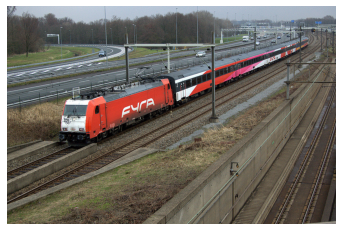

A large long train on a steel track.
A red and white train passing by a street.
A red train going down the track in the city.
A long red and white train travels near many other tracks.
Red and white commuter train riding down tracks next to the highway. 


In [3]:
# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id'])
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [10]:
import sys
import nltk
nltk.download('punkt')
from dataLoader import get_loader
from torchvision import transforms
import torch.utils.data as data

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Training Setup

We will customize the training of our CNN-RNN model by specifying hyperparameters and setting other options that are important to the training procedure.  The values we set now will be used when training our model. 

We begin by setting the following variables:
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model.  We recommend `num_epochs=5`. [Xu et al., 2016](https://arxiv.org/pdf/1502.03044.pdf) trained a captioning model on a single state-of-the-art GPU for 3 days, but we'll soon see that you can get reasonable results in a matter of a few hours!  (_But of course, if we want our model to compete with current research, we will have to train for much longer._)
- `save_every` - determines how often to save the model weights.  We recommend `save_every=1`, to save the model weights after each epoch.  This way, after the `i`th epoch, the encoder and decoder weights will be saved in the `models/` folder as `encoder-i.pkl` and `decoder-i.pkl`, respectively.
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  Note that we **will not** observe a monotonic decrease in the loss function while training - this is perfectly fine and completely expected!  We have to keep this at its default value of `100` to avoid clogging the notebook
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.

In [7]:
# Select appropriate values for the Python variables below.
batch_size = 32          # batch size
vocab_threshold = 6        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 5             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

In [6]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

# Import EncoderCNN and DecoderRNN. 
from model import EncoderCNN, DecoderRNN
import math
# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters())

# Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=1.74s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [01:09<00:00, 8534.74it/s]


## Train the model

In [8]:
# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
#         print("outputs.shape: ", outputs.shape)
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

Epoch [1/5], Step [200/18493], Loss: 3.5329, Perplexity: 34.2229
Epoch [1/5], Step [400/18493], Loss: 3.3127, Perplexity: 27.4580
Epoch [1/5], Step [600/18493], Loss: 3.3930, Perplexity: 29.7552
Epoch [1/5], Step [800/18493], Loss: 3.0110, Perplexity: 20.3068
Epoch [1/5], Step [1000/18493], Loss: 3.0645, Perplexity: 21.4239
Epoch [1/5], Step [1200/18493], Loss: 2.8749, Perplexity: 17.7238
Epoch [1/5], Step [1400/18493], Loss: 2.7819, Perplexity: 16.1504
Epoch [1/5], Step [1600/18493], Loss: 2.8112, Perplexity: 16.6294
Epoch [1/5], Step [1800/18493], Loss: 2.7968, Perplexity: 16.3925
Epoch [1/5], Step [2000/18493], Loss: 2.5173, Perplexity: 12.3948
Epoch [1/5], Step [2200/18493], Loss: 2.4497, Perplexity: 11.5853
Epoch [1/5], Step [2400/18493], Loss: 2.4799, Perplexity: 11.93981
Epoch [1/5], Step [2600/18493], Loss: 2.4141, Perplexity: 11.17992
Epoch [1/5], Step [2800/18493], Loss: 2.4141, Perplexity: 11.1795
Epoch [1/5], Step [3000/18493], Loss: 2.5502, Perplexity: 12.8092
Epoch [1/5],

## Plot Results

Now that the training is done, we can load the training log text file and plot the results to see how the model performed. The model was trained on just 5 epochs so we do not really have a strict requirement on its performance. We will plot the following features:

- `loss`: it indicates how well the model fits the training data.
- `perplexity`: a measurement of how well a probability model predicts a sample

In [48]:
# Load training log text file into a list
with open('training_log.txt') as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]
    file.close()

# Extract loss and perplexity from each line
loss = []
perplexity = []
for line in lines:
    loss_idx = line.find('Loss')                        # Find index of Loss
    loss.append(float(line[loss_idx+6:loss_idx+12]))    # Slice loss value with Loss index
    
    perplexity_idx = line.find('Perplexity')
    perplexity.append(float(line[perplexity_idx+12:]))

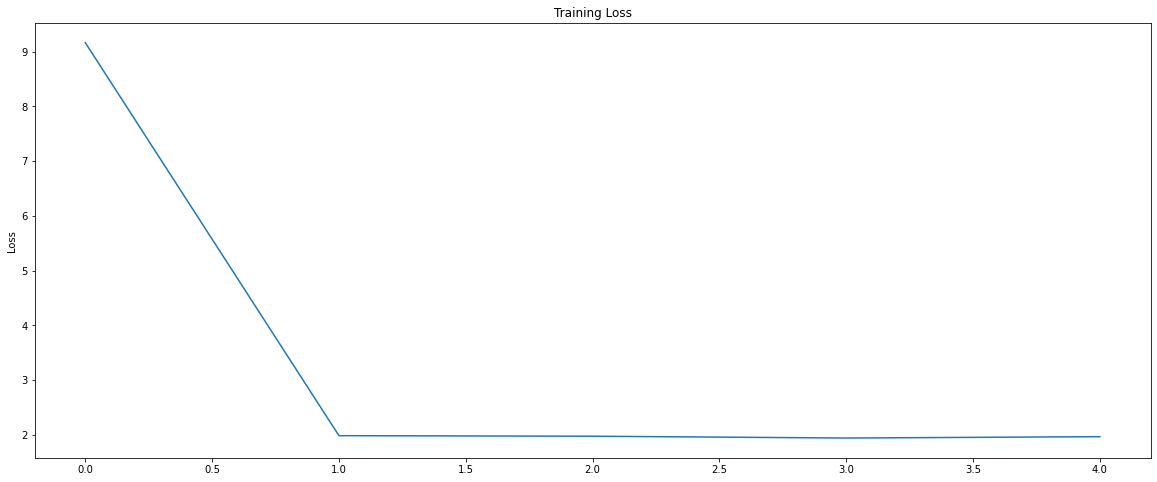

In [49]:
# Change loss and perplexity to arrays for easy plotting
loss = np.array([loss[0], loss[18493], loss[36986], loss[55479], loss[-1]])
perplexity = np.array([perplexity[18493], perplexity[36986], perplexity[55479], perplexity[73973], perplexity[92463]])

# Plot training loss and save figure
plt.plot(loss)
plt.rcParams["figure.figsize"] = (20,8)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.savefig('Training Loss')
plt.show()

In [50]:
perplexity

array([7.2708, 7.1984, 6.9634, 6.5107, 6.2161])

In [51]:
loss

array([9.1653, 1.9839, 1.9739, 1.9407, 1.9653])

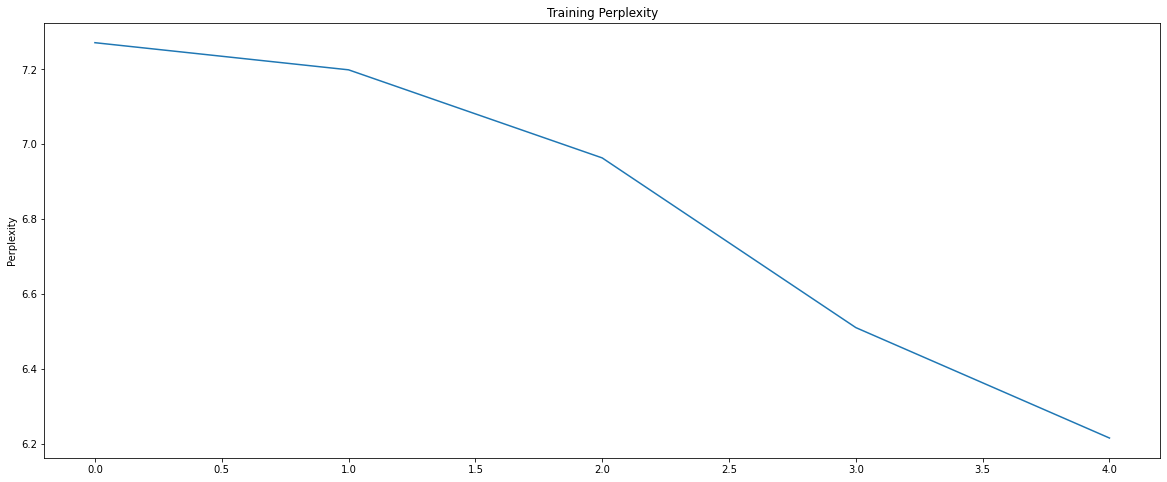

In [52]:
# Plot training perplexity and save figure
plt.plot(perplexity)
plt.rcParams["figure.figsize"] = (20,8)
plt.title('Training Perplexity')
plt.ylabel('Perplexity')
plt.savefig('Training Perplexity')
plt.show()

## Model Evaluation and Testing
To get a clear understanding of our model, we used the python 3 version of microsoft coco caption evaluation from  [Daqing Liu's Github](https://github.com/daqingliu/coco-caption) to evaluate our model. The metrics in this repo are bleu score, cider, meteor, rouge and spice. In order to get the accuracy of the metrics, the trained model is used to generate captions on the test set. We loaded the a new **data_loader** with the mode test to get the test data. Then we load our saved encoder and decoder and pass the images to generate captions. The out is stored in a json file and exported to the **results** directory.

In [98]:
from PIL import Image
import json

# Define a transform to pre-process the test images.
transform_test = transforms.Compose([transforms.Resize((224, 224)), \
                                     transforms.ToTensor(), \
                                     transforms.Normalize((0.485, 0.456, 0.406), \
                                                          (0.229, 0.224, 0.225))])

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='test',
                         batch_size=1)

Vocabulary successfully loaded from vocab.pkl file!


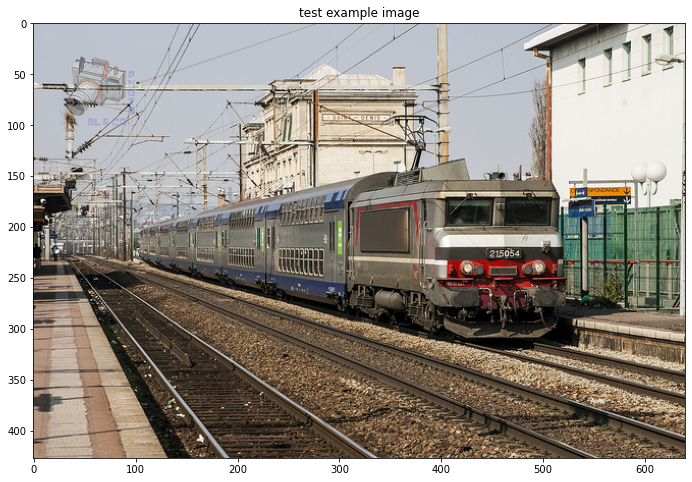

In [75]:
# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('test example image')
plt.show()

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify the saved models to load.
encoder_file = 'encoder-5.pkl' 
decoder_file = 'decoder-5.pkl'

# Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models/', encoder_file), map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(os.path.join('./models/', decoder_file), map_location=torch.device('cpu')))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (word_embeddings): Embedding(9438, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9438, bias=True)
)

In [77]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
print("image.shape: ", image.shape)
features = encoder(image).unsqueeze(1)
print("features.shape: ", features.shape)
print()

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('test example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that in"

image.shape:  torch.Size([1, 3, 224, 224])
features.shape:  torch.Size([1, 1, 512])

test example output: [0, 3, 612, 35, 49, 9, 1558, 39, 3, 612, 1107, 12, 1]


In [78]:
# Complete the function.
def clean_sentence(output):
    list_string = []
    
    for idx in output:
        list_string.append(data_loader.dataset.vocab.idx2word[idx])
    
    list_string = list_string[1:-1] # Discard <start> and <end> words
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    return sentence

In [79]:
sentence = clean_sentence(output)
print('Test example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

Test example sentence: A train is on the tracks in a train yard .


In [68]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

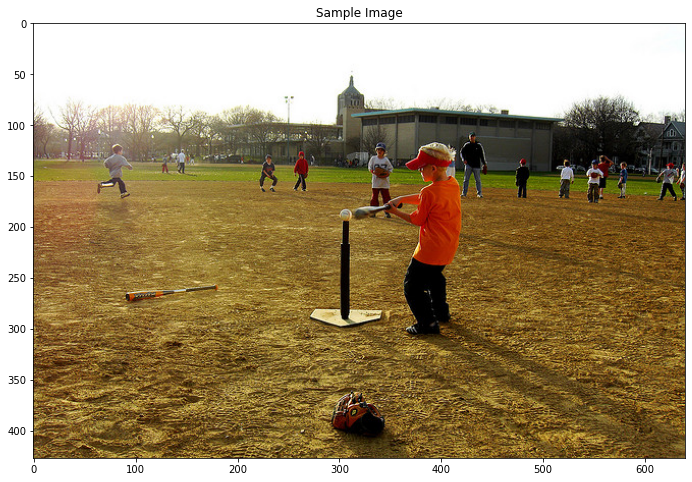

A baseball player is about to swing at a pitch .


In [71]:
get_prediction()

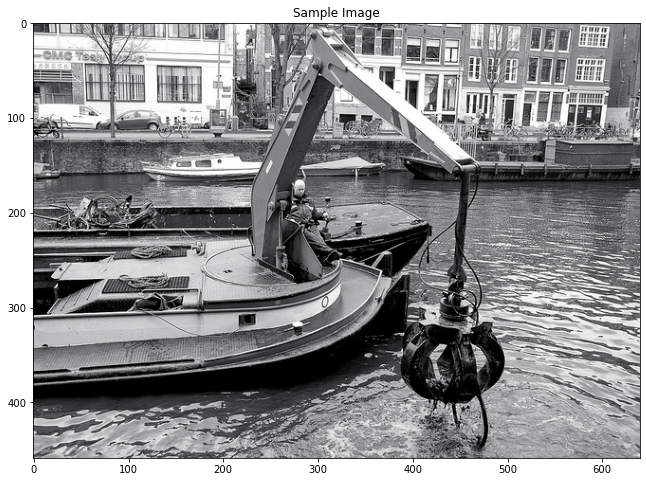

A boat traveling on the water near a bridge .


In [72]:
get_prediction()

In [100]:
# Evaluate the validation set using the above metrics
img_ids = []
count = 0
json_dumps = []
while count < 1000:
    # Load a random image from val2017
    cocoapi_loc='./coco'
    img_folder = os.path.join(cocoapi_loc, 'images/val2017/')
    ann_id = np.random.choice(ids)
    img_id = coco.anns[ann_id]['image_id']
    if img_id in img_ids:
        continue
    else:
        img_ids.append(img_id)
        img = coco.loadImgs(img_id)[0]
        path = coco.loadImgs(img_id)[0]['file_name']
        image = Image.open(os.path.join(img_folder, path)).convert('RGB')
        annIds = coco_caps.getAnnIds(imgIds=img['id'])
        anns = coco_caps.loadAnns(annIds)
    
        # Load the caption of the image
        captions = [anns[i]['caption'].split() for i in range(len(anns))]
    
        # transform image to tensor
        image = transform_test(image)
    
        # change tensor to 4D
        image = torch.reshape(image, (1,3,224,224))
    
        # Feed tensor to the encoder and decoder
        image = image.to(device)            
        features = encoder(image).unsqueeze(1)
        output = decoder.sample(features)
    
        # Get predicted caption
        sentence = clean_sentence(output)
        json_dumps.append({"image_id": img_id, "caption": sentence}) 
        count += 1

In [104]:
val_json = json.dumps(json_dumps)

# Write generated captions to json file 
with open('validation_captions.json', 'w') as outfile:
    outfile.write(val_json)

In [106]:
# import libraries for evaluation
from pycocoevalcap.eval import COCOEvalCap
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [112]:
# set up file names and pathes
dataDir='.'
dataType='val2017'
algName = 'fakecap'
annFile='%s/coco/annotations/captions_%s.json'%(dataDir,dataType)
subtypes=['results', 'evalImgs', 'eval']
[resFile, evalImgsFile, evalFile]= \
['%s/results/captions_%s_%s_%s.json'%(dataDir,dataType,algName,subtype) for subtype in subtypes]

In [113]:
# create coco object and cocoRes object
coco = COCO(annFile)
cocoRes = coco.loadRes(resFile)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [115]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(coco, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
cocoEval.evaluate()

tokenization...


PTBTokenizer tokenized 61795 tokens at 328325.81 tokens per second.
PTBTokenizer tokenized 11840 tokens at 91950.81 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9849, 'reflen': 9744, 'guess': [9849, 8849, 7849, 6849], 'correct': [5899, 2340, 888, 372]}
ratio:1.010776
Bleu_1: 0.599
Bleu_2: 0.398
Bleu_3: 0.262
Bleu_4: 0.177
computing METEOR score...
METEOR: 0.184
computing Rouge score...
ROUGE_L: 0.437
computing CIDEr score...
CIDEr: 0.499
computing SPICE score...


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.2 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classif

SPICE evaluation took: 1.052 min
SPICE: 0.115


## Results from Evaluation

In [117]:
# print output evaluation scores
for metric, score in cocoEval.eval.items():
    print( '%s: %.3f'%(metric, score))

Bleu_1: 0.599
Bleu_2: 0.398
Bleu_3: 0.262
Bleu_4: 0.177
METEOR: 0.184
ROUGE_L: 0.437
CIDEr: 0.499
SPICE: 0.115


## Display images captions from metrics

ground truth captions
Bartender opening a bottle of wine while patron waits patiently
A bartender opening a bottle with a rag.
Hey man that is opening up a bottle of wine.
A young man serving wine at a bar.
A bartender opens a wine bottle with a towel. 


generated caption (CIDEr score 0.1)
A man is sitting at a table with a plate of food .


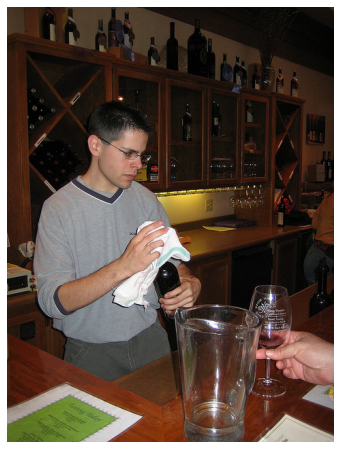

In [242]:
# retrieve low score result for CIDEr
evals = [eva for eva in cocoEval.evalImgs if eva['CIDEr']<0.10]
print ('ground truth captions')
imgId = evals[6]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print ('\n')
print ('generated caption (CIDEr score %0.1f)'%(evals[0]['CIDEr']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/coco/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

ground truth captions
A professional rider is riding a horse outside
a man is riding a brown horse down a green field
The person is riding a horse in the pen.
A young girl rides her horse in the middle of a course.
a girl in full riding gear riding a brown horse


generated caption (CIDEr score 3.2)
A man is riding a horse in a field


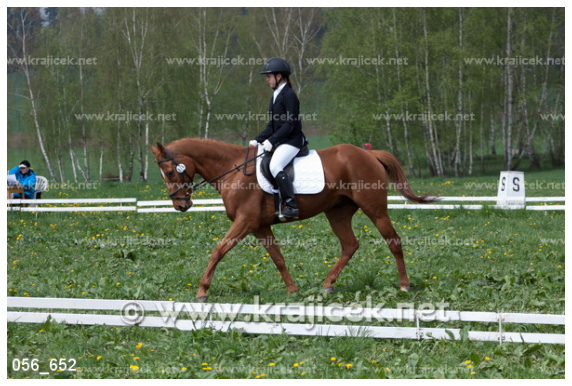

In [235]:
# retrieve a better score result for CIDEr
evals = [eva for eva in cocoEval.evalImgs if eva['CIDEr']>2.80]
print ('ground truth captions')
imgId = evals[4]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print ('\n')
print ('generated caption (CIDEr score %0.1f)'%(evals[0]['CIDEr']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/coco/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

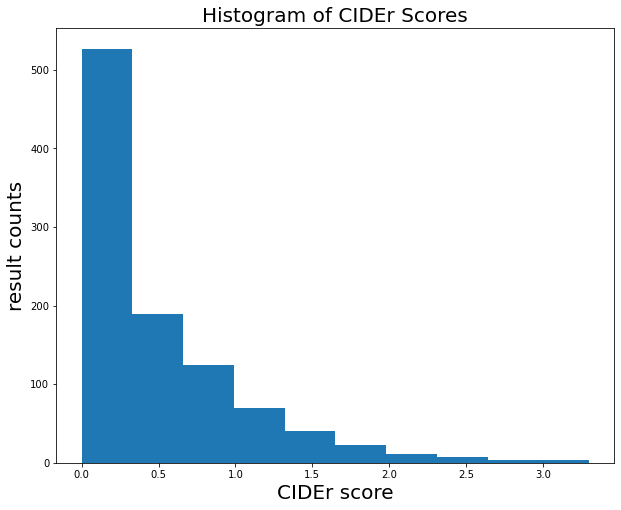

In [229]:
# plot score histogram for CIDEr scores
ciderScores = [eva['CIDEr'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of CIDEr Scores', fontsize=20)
plt.xlabel('CIDEr score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.savefig('CIDEr Scores')
plt.show()

ground truth captions
Two surfers in wetsuits carrying surfboards along the beach.
two surfers walking along the ocean beach in the sand
Two people in wetsuits on beach next to water and buildings.
Two people holding surfboards walk down a beach.
Two surfers walking on a beach to the ocean.


generated caption (Bleu_1 score 0.2)
A man riding a surfboard on top of a wave .


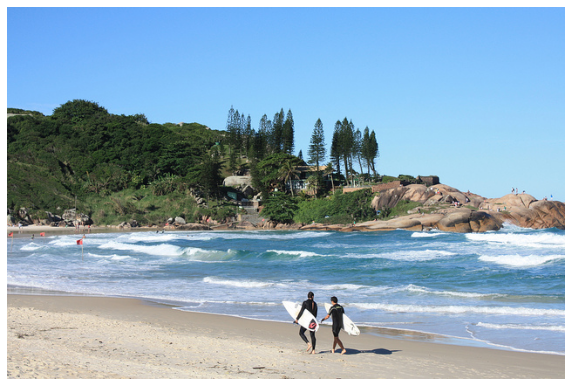

In [228]:
# retrieve low score result for Bleu_1
evals = [eva for eva in cocoEval.evalImgs if eva['Bleu_1']<0.20]
print ('ground truth captions')
imgId = evals[5]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print ('\n')
print ('generated caption (Bleu_1 score %0.1f)'%(evals[0]['Bleu_1']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/coco/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

ground truth captions
a group of people sit around a big table 
a family sitting around a long table filled with a lot of food 
A lot of people sitting around a table full of food.
a large family enjoying a dinner on a large table 
Lots of people at a long table eating, drinking and smiling


generated caption (Bleu_1 score 1.0)
A group of people sitting at a table with plates of food .


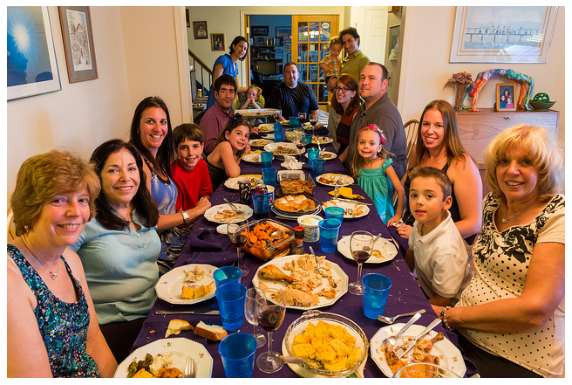

In [223]:
# retrieve a better score result for Bleu_1
evals = [eva for eva in cocoEval.evalImgs if eva['Bleu_1'] > 0.90]
print ('ground truth captions')
imgId = evals[2]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print ('\n')
print ('generated caption (Bleu_1 score %0.1f)'%(evals[0]['Bleu_1']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/coco/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

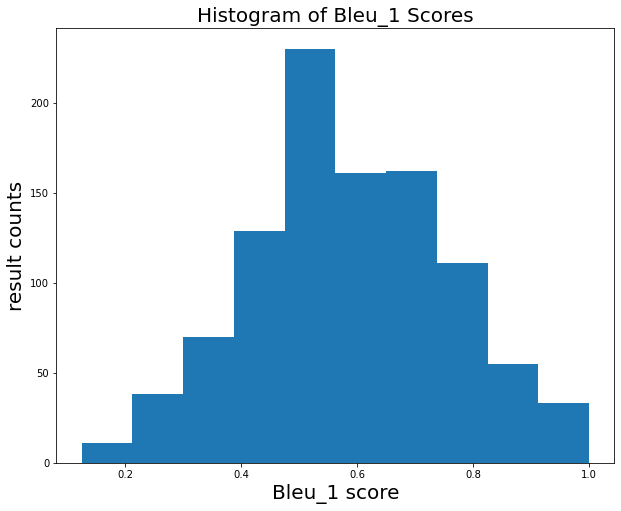

In [161]:
# plot score histogram for Bleu_1 scores
ciderScores = [eva['Bleu_1'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of Bleu_1 Scores', fontsize=20)
plt.xlabel('Bleu_1 score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.show()

ground truth captions
Two men smile as they ride horses on the beach.
two guys horseback riding and playing on the beach.
Two men are riding horses along the beach.
Two people on horseback are posing while the horses gallop on a beach shore.
Two people on horses on a beach readying for a picture


generated caption (Bleu_2 score 0.0)
A man and woman are standing in the water .


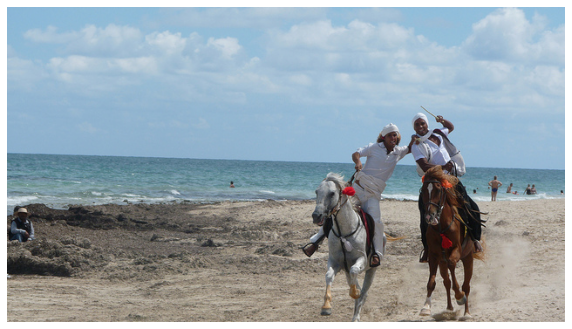

In [165]:
# retrieve low score result for Bleu_2
evals = [eva for eva in cocoEval.evalImgs if eva['Bleu_2']<0.20]
print ('ground truth captions')
imgId = evals[0]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print ('\n')
print ('generated caption (Bleu_2 score %0.1f)'%(evals[0]['Bleu_2']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/coco/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

ground truth captions
Different views of a man who is skateboarding.
A person with duplicate images of himself skateboarding.
Boys in a school uniform skateboarding on a concrete ramp.
Many young men ride their skateboards on a ramp. 
A man riding a skateboard up the side of a ramp.


generated caption (Bleu_2 score 0.9)
A man riding a skateboard on a ramp .


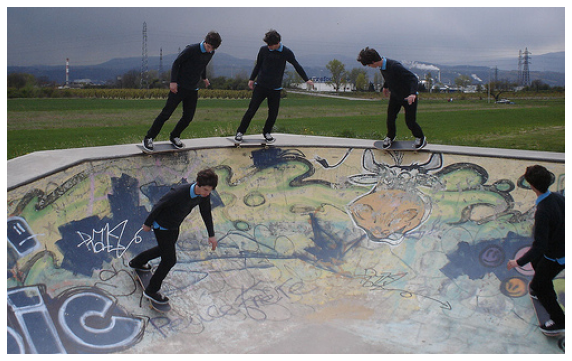

In [217]:
# retrieve a better score result for Bleu_2
evals = [eva for eva in cocoEval.evalImgs if eva['Bleu_2']>0.90]
print ('ground truth captions')
imgId = evals[3]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print ('\n')
print ('generated caption (Bleu_2 score %0.1f)'%(evals[0]['Bleu_2']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/coco/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

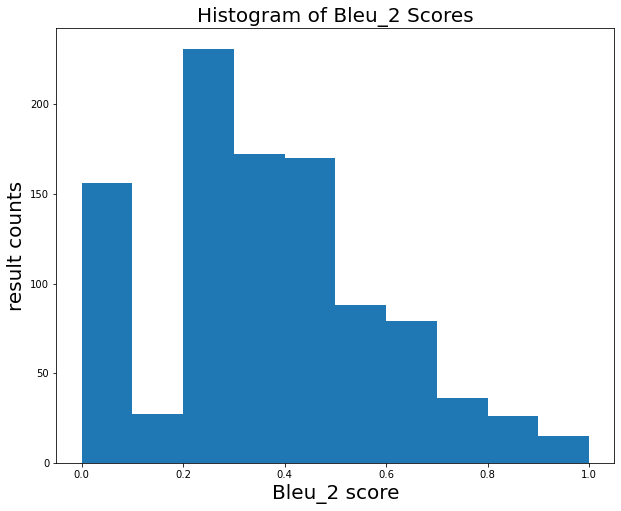

In [213]:
# plot score histogram for Bleu_2 scores
ciderScores = [eva['Bleu_2'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of Bleu_2 Scores', fontsize=20)
plt.xlabel('Bleu_2 score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.savefig('Bleu_2 Scores')
plt.show()

ground truth captions
A man is shaking hands with another man.
Two men shake hands at a formal dinner gathering.
Two men standing next to each other holding hands.
Two men are shaking hands at a social gathering.
Two men shaking hands after a dinner speech.


generated caption (Bleu_3 score 0.0)
A man and a woman are standing in a booth .


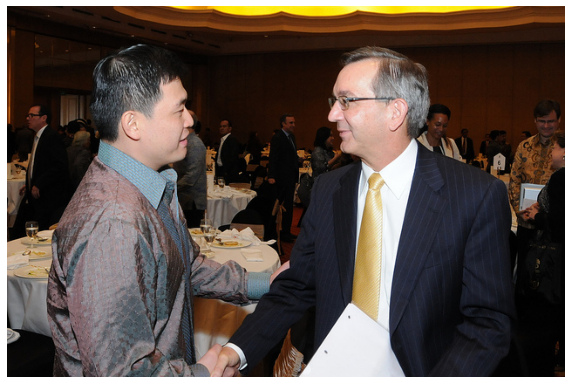

In [212]:
# retrieve low score result for Bleu_3
evals = [eva for eva in cocoEval.evalImgs if eva['Bleu_3']<0.20]
print ('ground truth captions')
imgId = evals[2]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print ('\n')
print ('generated caption (Bleu_3 score %0.1f)'%(evals[0]['Bleu_3']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/coco/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

ground truth captions
A group of people flying kites on a grassy field next to buildings.
Many people walk through a park as few kites fly in the air.
People are flying kites in the park and walking.
People fly kites in a large park in the middle of a city.
People flying kites in a park on a windy day.
People flying kites in a park on a windy day.


generated caption (Bleu_3 score 0.9)
A group of people flying kites in a field .


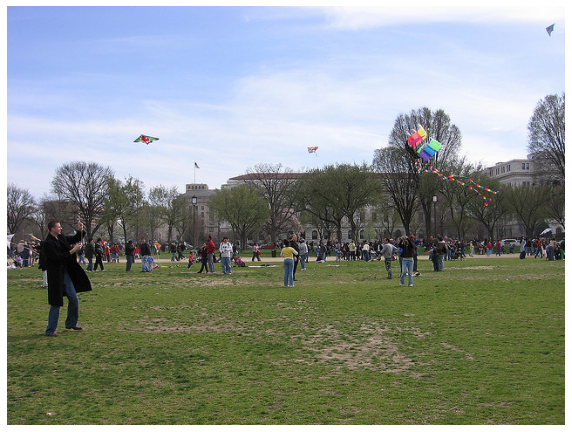

In [210]:
# retrieve a better score result for Bleu_3
evals = [eva for eva in cocoEval.evalImgs if eva['Bleu_3']>0.90]
print ('ground truth captions')
imgId = evals[0]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print ('\n')
print ('generated caption (Bleu_3 score %0.1f)'%(evals[0]['Bleu_3']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/coco/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

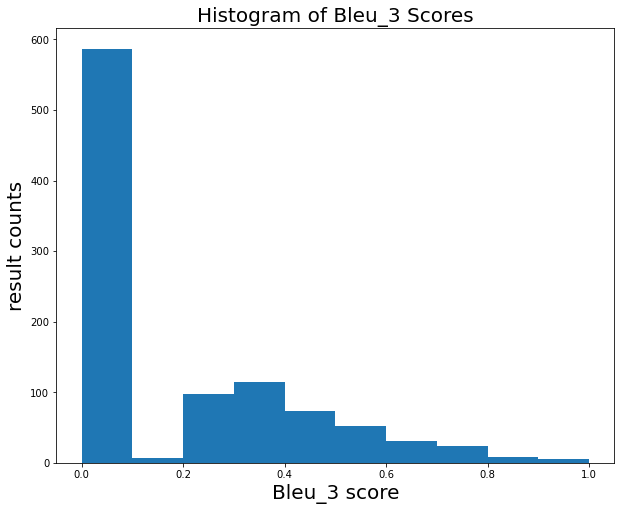

In [208]:
# plot score histogram for Bleu_3 scores
ciderScores = [eva['Bleu_3'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of Bleu_3 Scores', fontsize=20)
plt.xlabel('Bleu_3 score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.savefig('Bleu_3 Scores')
plt.show()

ground truth captions
A stop sign is mounted upside-down on it's post. 
A stop sign that is hanging upside down.
An upside down stop sign by the road.
a stop sign put upside down on a metal pole 
A stop sign installed upside down on a street corner


generated caption (Bleu_4 score 0.0)
A stop sign with a sticker on it


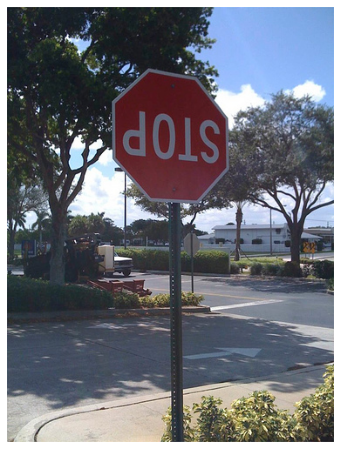

In [173]:
# retrieve low score result for Bleu_4
evals = [eva for eva in cocoEval.evalImgs if eva['Bleu_4']<0.20]
print ('ground truth captions')
imgId = evals[0]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print ('\n')
print ('generated caption (Bleu_4 score %0.1f)'%(evals[0]['Bleu_4']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/coco/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

ground truth captions
there is a male surfer that is riding in the wave
a man on a surf board rides a wave 
A man in a wet suit riding a wave on a surf board.

A man that is on a surfboard in the water.
A surfer in the ocean on the crest of a wave.


generated caption (Bleu_4 score 0.8)
A man riding a wave on a surfboard in the ocean .


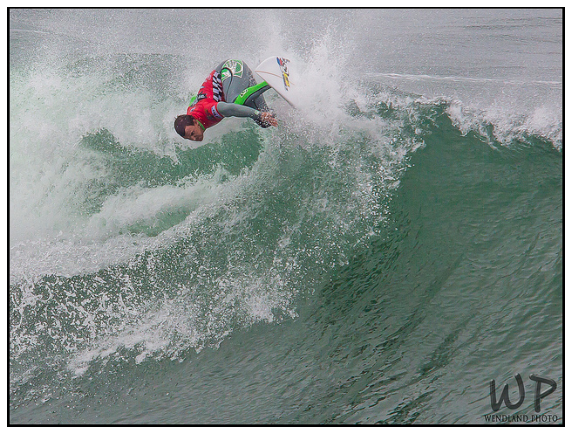

In [206]:
# retrieve a better score result for Bleu_4
evals = [eva for eva in cocoEval.evalImgs if eva['Bleu_4']>0.70]
print ('ground truth captions')
imgId = evals[0]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print ('\n')
print ('generated caption (Bleu_4 score %0.1f)'%(evals[0]['Bleu_4']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/coco/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

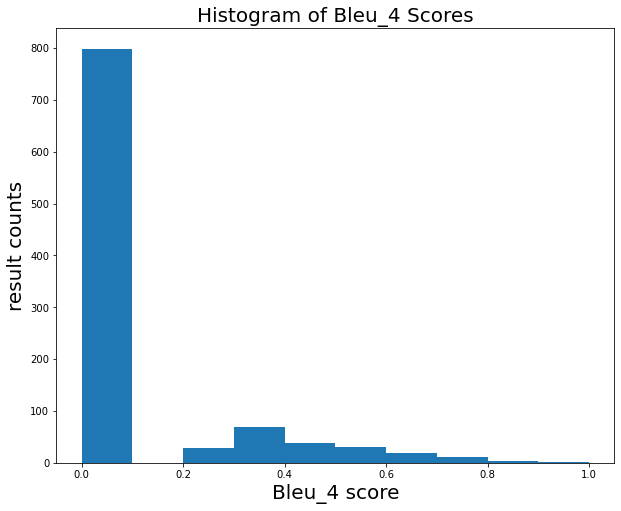

In [207]:
# plot score histogram for Bleu_4 scores
ciderScores = [eva['Bleu_4'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of Bleu_4 Scores', fontsize=20)
plt.xlabel('Bleu_4 score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.savefig('Bleu_4 Scores')
plt.show()

ground truth captions
A man in a wet suit stands on a surfboard and rows with a paddle.
A paddle boarder on a large, still body of water.
A man is holding a long racquet on a surfboard in the middle of the sea.
Black and white of a person wearing a wetsuit standing on a surfboard and holding out a paddle, in a large body of water outside.
A man with a wet suit on standing on a surfboard in the water.


generated caption (METEOR score 0.2)
A man riding a surfboard on top of a wave .


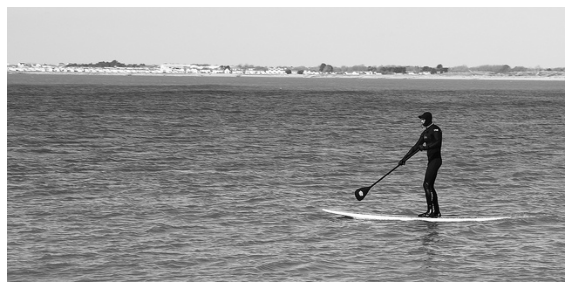

In [176]:
# retrieve low score result for METEOR
evals = [eva for eva in cocoEval.evalImgs if eva['METEOR']<0.20]
print ('ground truth captions')
imgId = evals[0]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print ('\n')
print ('generated caption (METEOR score %0.1f)'%(evals[0]['METEOR']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/coco/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

ground truth captions
A man riding skis down a snow covered slope.
A person skiing down a mountain in the snow.
a big hill that has a bunch of snow on it
a man skiing down a hill by himself 
The man is skiing down the snowy slopes.


generated caption (METEOR score 0.9)
A person riding skis down a snow covered slope .


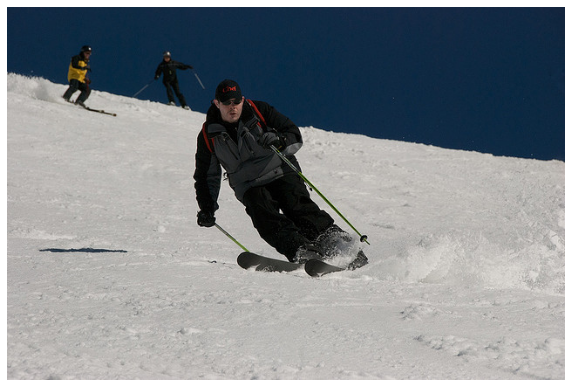

In [205]:
# retrieve a better score result for METEOR
evals = [eva for eva in cocoEval.evalImgs if eva['METEOR']>0.70]
print ('ground truth captions')
imgId = evals[0]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print ('\n')
print ('generated caption (METEOR score %0.1f)'%(evals[0]['METEOR']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/coco/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

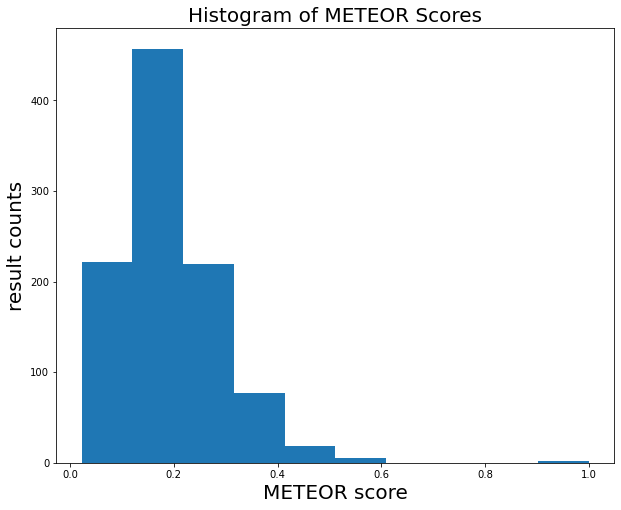

In [204]:
# plot score histogram for METEOR scores
ciderScores = [eva['METEOR'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of METEOR Scores', fontsize=20)
plt.xlabel('METEOR score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.savefig('METEOR Scores')
plt.show()

ground truth captions
Several cars are parked in front of a building.
A green car has parked on the curb in a parking lot
Small parking lot of cars in front of a stone building.
Cars are parked on the the street in front of the building.
Cars are parked on the street near an old building.


generated caption (ROUGE_L score 0.2)
A street with a bunch of people walking around


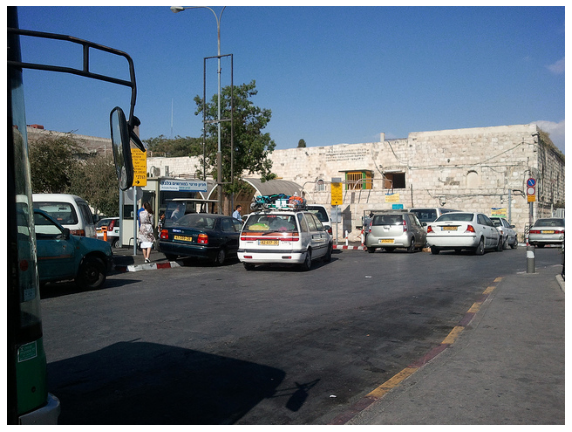

In [197]:
# retrieve low score result for ROUGE_L
evals = [eva for eva in cocoEval.evalImgs if eva['ROUGE_L']<0.20]
print ('ground truth captions')
imgId = evals[0]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print ('\n')
print ('generated caption (ROUGE_L score %0.1f)'%(evals[0]['ROUGE_L']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/coco/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

ground truth captions
some people seated at a table with plates of food 
A woman with her hand over her glass while sitting at a dinner table.
A group of people sitting at a table.
A woman and child sitting at table with food and drinks.
A family dines at a packed sushi bar and buffet


generated caption (ROUGE_L score 0.8)
A group of people sitting at a table with food .


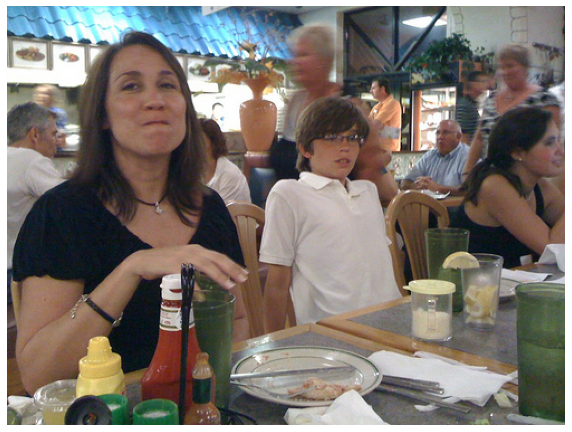

In [191]:
# retrieve a better score result for ROUGE_L
evals = [eva for eva in cocoEval.evalImgs if eva['ROUGE_L']>0.80]
print ('ground truth captions')
imgId = evals[5]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print ('\n')
print ('generated caption (ROUGE_L score %0.1f)'%(evals[0]['ROUGE_L']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/coco/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

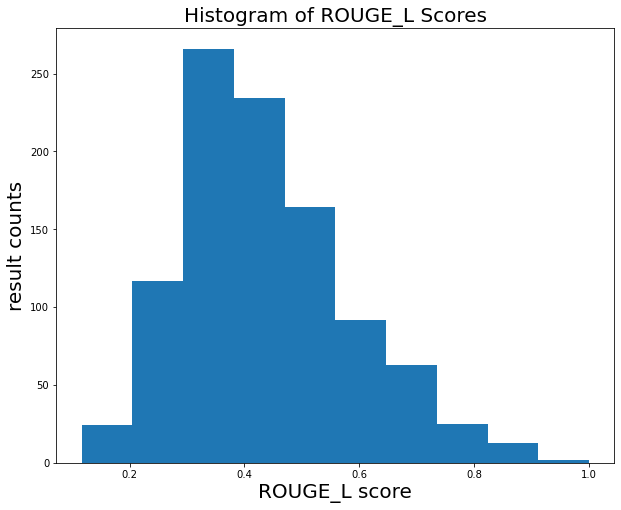

In [203]:
# plot score histogram for ROUGE_L scores
ciderScores = [eva['ROUGE_L'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of ROUGE_L Scores', fontsize=20)
plt.xlabel('ROUGE_L score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.savefig('ROUGE_L Scores')
plt.show()

## Conclusion

We see from the below table that BLEU -1 has the accuracy of 59% and has outperformed other variations of BLEU (Basically weights have been varied to get the different variations and the second-best accuracy is CIDEr with 49%. Captions on the images were fairly good with 5 epochs. Perharps, with fine tuned parameters and more epochs, it would have performed better.